In [1]:
import numpy as np
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
import astropy.units as u
import astropy.visualization as vis
from regions import CircleSkyRegion
from gammapy.data import ObservationFilter
from gammapy.makers import ReflectedRegionsFinder
import scanner_interpretation as scani
from scipy.stats import expon
import dill
import matplotlib.pyplot as plt

In [2]:
## Loading data
rd = scani.Reduced("pkl_jugs/n4/reduced_complete.pkl")
hbl = rd.reduced[rd.reduced["OBS_ID"]==35007][0]
hbl

Nmax,OBS_ID,ID,RA,DEC,TIME,ENERGY,dt,da,MEDIAN_RA,MEDIAN_DEC,SkyCoord,MEDIAN_GLAT,MEDIAN_GLON,TEVCAT_SOURCE_NAME,TEVCAT_SOURCE_TYPE,TEVCAT_DISTANCES_DEG,TEVCAT_FLUX_CRAB,DS_INDEX,ANGULAR_MEASURE_DEG,ALT_PNT,PNT_SOURCE,PNT_DISTANCE,BKG_DT_LAMBDA,BKG_PHOTONS,MPLET_DT_LAMBDA,LAMBDA_RATIO_SIGNIFICANCE,BELL_FRACTION,EXP_CORRECTED_P,BERNOULLI_P,BERNOULLI_SIGMA
,,,,,,,,,,,"deg,deg",deg,deg,,,,,,,,,,,,,,,,,
int64,uint32,object,object,object,object,object,float64,float64,float64,float64,SkyCoord,float64,float64,str21,str22,float64,object,int64,float64,float64,str18,float64,float64,int64,float64,float64,float64,float64,float64,float64
4,35007,[12300786336303 12300786336309 12300786336358 12305081303052],[0.58403856 0.526088 0.45749614 0.4166997 ],[-31.82828 -31.751549 -31.768085 -31.768494],['2006-09-24T22:28:53.679578835' '2006-09-24T22:28:53.709489638'\n '2006-09-24T22:28:53.971949393' '2006-09-24T22:28:54.285595948'],[0.40224195 0.19593626 0.30666494 0.5964279 ],606017024.0,0.177698162902297,0.49179208278656006,-31.76828956604004,"0.49179208278656006,-31.76828956604004",-78.28313920052501,6.65861855121281,NGC 253,Starburst,13.000918161333757,None,0,0.0652376582121839,81.2128422884387,Fornax A east lobe,1.1460470590280671,0.002343300317735979,4,4.950355255066865e-09,5.345723863570129e-13,0.0008089494076557457,1.582010297340254e-05,1.5819978994802142e-05,4.316950259487835


In [3]:
hess1 = scani.getDataStores()[0]
obs = hess1.obs(hbl["OBS_ID"])

## Setup
radius = Angle(0.1,"deg")
on_region = CircleSkyRegion(hbl["SkyCoord"], radius)
pointing = SkyCoord(obs.obs_info["RA_PNT"],obs.obs_info["DEC_PNT"], frame="fk5", unit="deg")


In [4]:
finder = ReflectedRegionsFinder()
reflected_regions = finder.run(region = on_region, center = pointing)


In [5]:
bkg_rates = []
photon_count = []
for region in reflected_regions[0]:
    selection = obs.events.select_region(region)
    photon_count.append(len(selection.table))

    arrival_times = selection.table["TIME"]
    bkg_rates.append(1e-9/expon.fit(np.diff(np.sort(arrival_times)),floc=0.)[1])

In [6]:
reflected_regions_tab = Table([reflected_regions[0],bkg_rates,photon_count],names=["REGION","BKG_RATE","PHOTON_COUNT"])

In [ ]:
reflected_regions_tab

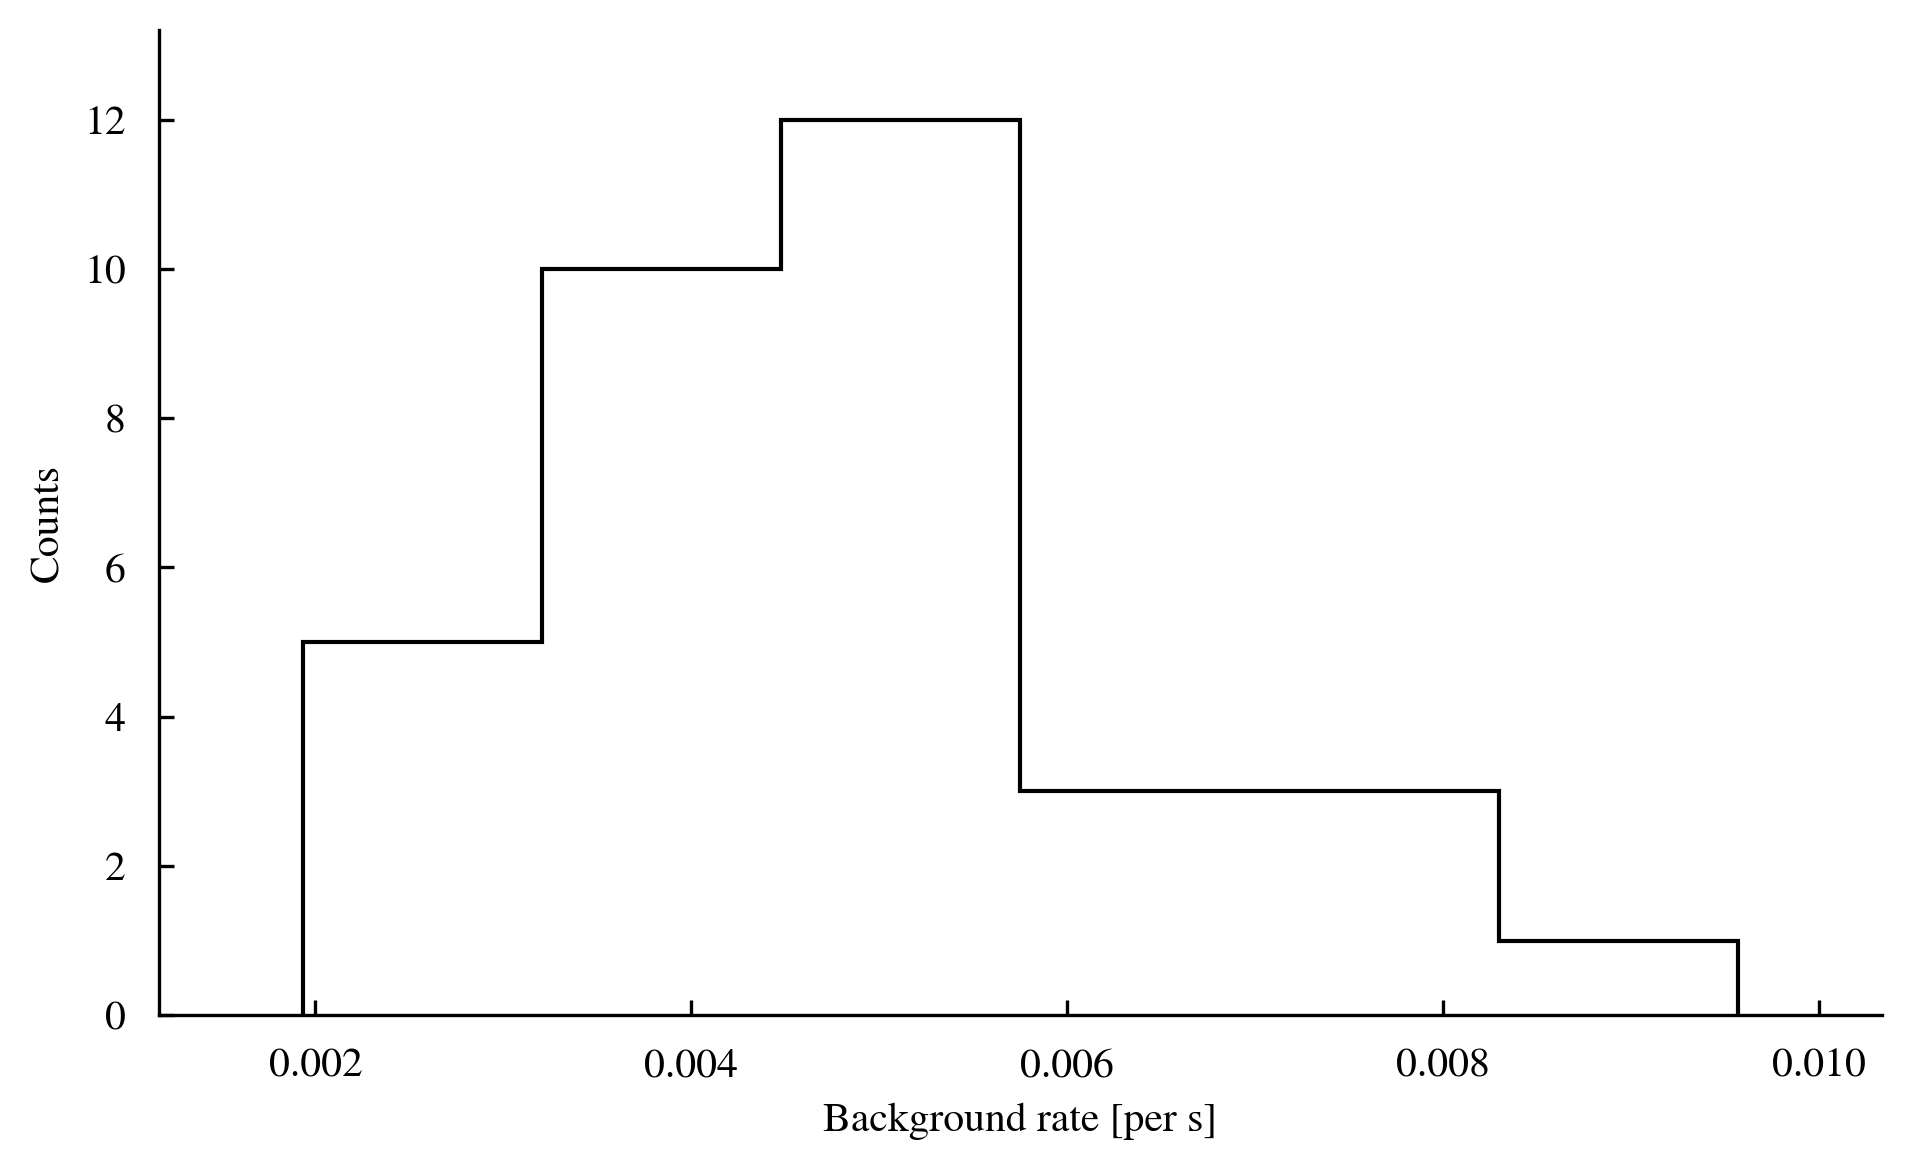

In [7]:
h = vis.hist(reflected_regions_tab["BKG_RATE"]*1e9,histtype="step",bins="freedman")
plt.xlabel("Background rate [per s]")
plt.ylabel("Counts")
plt.show()

In [9]:
estim_bkg_rate = np.median(reflected_regions_tab["BKG_RATE"])

In [11]:
estim_bkg_rate * 1e9

0.004720429030334075

In [ ]:
expected_in_dt = hbl["Nmax"] * estim_bkg_rate / hbl["MPLET_DT_LAMBDA"]
from math import factorial
sum = 1
for i in range(hbl["Nmax"]):
    sum -= np.exp(-expected_in_dt) * expected_in_dt**i / factorial(i)


p = sum / hbl["BELL_FRACTION"]
rc = scani.get_total_runcount(scani.getDataStores())
pval = (1-(1-p)**rc)
print(pval,scani.n_sigmas(pval))

In [ ]:
obs.obs_info